To begin copy this notebook to your own drive:

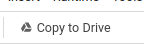


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:02<00:00, 195MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 24.1MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 91.5 MB/s eta 0:00

In [4]:
!pip uninstall transformers -y
#!pip install torch "argilla" datasets accelerate transformers setfit
!pip install transformers==4.28.0

Found existing installation: transformers 4.29.2
Uninstalling transformers-4.29.2:
  Successfully uninstalled transformers-4.29.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 91.8 MB/s eta 0:00:00


In [5]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [7]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [8]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [9]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-9-c6aba47c7ef1>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [10]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


###Part A

In [ ]:
# PART A 
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.layers = nn.Sequential(
              nn.Linear(300, 450),
              nn.ReLU(),
              nn.Linear(450, 100),
              nn.ReLU(),
              nn.Linear(100, 50),
              nn.ReLU(),
              nn.Linear(50, 10),
              nn.ReLU(),
              nn.Linear(10,self.num_labels),
          )   
          self.classifier = nn.Sequential(
              self.layers
          )
          self.loss = nn.CrossEntropyLoss(reduction= 'sum') 
          # END YOUR END


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      device = torch.device("cuda:0")
      
      # without dropout for part (a)
      sumofembed =torch.sum(self.embeddings(input_ids), dim=1).type(torch.FloatTensor)
      attention_vector_per_sample = torch.sum(attention_masks, dim=1,keepdim = True).type(torch.FloatTensor)
      attention_vector_per_sample = torch.sum(attention_masks, dim=1,keepdim = True).type(torch.FloatTensor)
      avg = sumofembed / attention_vector_per_sample
      avg = avg.to(device) #for running on GPU, for nn.linear both input and avg should be on the same device.  
      # END YOUR END
  
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}


In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
#from transformers.callbacks import PrinterCallback, ProgressCallback
import numpy as np
import matplotlib.pyplot as plt
import math
import time

class MyCallbacks(TrainerCallback):
    def _init_(self):
        super().__init__()
        self.epochs_lst = None
        self.accuracy_over_epochs_lst = None
        self.accuracy_over_learning_rate_lst = None
        self.learning_rate_lst = None
       
    def on_train_begin(self, args, state, control, **kwargs):
        self.epochs_lst = []
        self.accuracy_over_epochs_lst = []

        
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        self.accuracy_over_epochs_lst.append(metrics['eval_accuracy'])
        self.epochs_lst.append(state.epoch)
    
        if (state.epoch == args.num_train_epochs):
          plt.plot(self.epochs_lst, self.accuracy_over_epochs_lst)
          plt.xlabel('Epochs')
          plt.ylabel('Accuracy')
          plt.title(f'The Accuracy over epoches with initial learing rate of {args.learning_rate}')
          annot_max(self.epochs_lst,self.accuracy_over_epochs_lst)
          plt.show()

In [ ]:
#taken from https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot
def annot_max(x,y, ax=None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)





/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.361600,3.233814,0.826440
2,3.278500,3.332046,0.809720
3,3.370300,4.243687,0.773400
4,3.152300,3.515018,0.823200
5,3.226500,3.256466,0.834760
6,3.073300,3.179518,0.829200
7,3.162400,3.219890,0.830520
8,3.139200,3.100209,0.836840
9,3.014000,4.448190,0.793160
10,3.021700,3.362509,0.831040


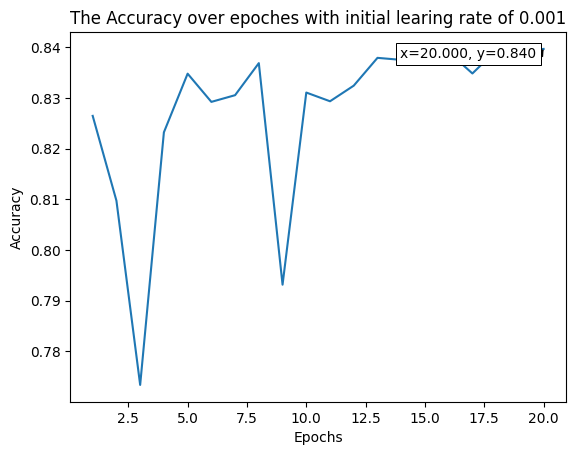

TrainOutput(global_step=62500, training_loss=3.07637243359375, metrics={'train_runtime': 962.8743, 'train_samples_per_second': 519.279, 'train_steps_per_second': 64.91, 'total_flos': 0.0, 'train_loss': 3.07637243359375, 'epoch': 20.0})

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
#from transformers.callbacks import PrinterCallback, ProgressCallback
import numpy as np
import matplotlib.pyplot as plt
import math
import time

mycallbacks = MyCallbacks()
co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs = 20 , #must be at least 10.
                                  per_device_train_batch_size = 8,
                                  per_device_eval_batch_size = 8,
                                  learning_rate = np.power(10,-3.0),
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                # YOUR CODE HERE
                mycallbacks
                # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

#Part B -Dropout

In [ ]:

from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN_DropOut(nn.Module):
  def __init__(self,dropout_prob):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          self.p = dropout_prob
          # YOUR CODE HERE
          self.layers = nn.Sequential(
              nn.Linear(300, 450),
              nn.ReLU(),
              nn.Linear(450, 100),
              nn.ReLU(),
              nn.Linear(100, 50),
              nn.ReLU(),
              nn.Linear(50, 10),
              nn.ReLU(),
              nn.Linear(10,self.num_labels),
          )
                      
          self.classifier = nn.Sequential(
              self.layers
          )
          self.loss = nn.CrossEntropyLoss(reduction= 'sum') 
          # END YOUR END


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      device = torch.device("cuda:0")
      #IMPLEMENTING DROPOUT 
      dropout_mask = torch.empty_like(input_ids).bernoulli_(1 - p)
      input_ids = dropout_mask * input_ids # preforming dropout mask 
      attention_masks =  dropout_mask * attention_masks # preforming dropout mask
      
      sumofembed =torch.sum(self.embeddings(input_ids), dim = 1).type(torch.FloatTensor)
      
      attention_vector_per_sample = torch.sum(attention_masks, dim = 1,keepdim = True).type(torch.FloatTensor)
      avg = sumofembed / attention_vector_per_sample
      avg = avg.to(device) #for running on GPU, for nn.linear both input and avg should be on the same device. 
      # END YOUR END
  
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [ ]:
#taken from https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot
def annot_max(x,y, ax=None):

    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)





Training with dropout probability 0.0

	 prams: num of epoches 12,
 
	 prams: batchsize 8,
 
	 prams: learning rate 0.001,
 
	 prams: hidden dims [450,100,50,10] 
 


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.440700,3.504746,0.815280
2,3.252300,3.153254,0.823440
3,3.353400,3.636964,0.806000
4,3.141900,3.275615,0.830000
5,3.185900,3.526264,0.819880
6,3.023600,3.210428,0.829080
7,3.123300,3.200738,0.832280
8,3.049900,3.133130,0.834520
9,2.936300,3.348953,0.833360
10,2.933400,3.208236,0.838120


Training with dropout probability 0.05

	 prams: num of epoches 12,
 
	 prams: batchsize 8,
 
	 prams: learning rate 0.001,
 
	 prams: hidden dims [450,100,50,10] 
 


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.405100,3.464085,0.824280
2,3.306300,3.946489,0.766360
3,3.352800,3.642280,0.805600
4,3.182200,3.234975,0.827520
5,3.185900,3.447917,0.827920
6,3.067600,3.192905,0.831640
7,3.159000,3.186553,0.830680
8,3.079200,3.124271,0.832560
9,2.945000,3.225210,0.832280
10,2.942600,3.197384,0.835400


Training with dropout probability 0.1

	 prams: num of epoches 12,
 
	 prams: batchsize 8,
 
	 prams: learning rate 0.001,
 
	 prams: hidden dims [450,100,50,10] 
 


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.594900,3.459225,0.808320
2,3.474400,4.048026,0.784520
3,3.367800,3.932334,0.784200
4,3.272700,3.266880,0.826120
5,3.315500,3.381311,0.818920
6,3.148900,3.288219,0.825320
7,3.242700,3.223277,0.824760
8,3.162500,3.204106,0.828240
9,3.067500,3.237369,0.826720
10,3.072700,3.234371,0.829680


Training with dropout probability 0.2

	 prams: num of epoches 12,
 
	 prams: batchsize 8,
 
	 prams: learning rate 0.001,
 
	 prams: hidden dims [450,100,50,10] 
 


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.468200,3.491899,0.805640
2,3.366200,3.777768,0.772880
3,3.412900,3.565481,0.800080
4,3.303800,3.476933,0.809880
5,3.319400,3.575289,0.814480
6,3.215200,3.427699,0.820920
7,3.280300,3.342084,0.818880
8,3.206700,3.229531,0.826320
9,3.063600,3.400074,0.819280
10,3.089100,3.327001,0.825400


Training with dropout probability 0.3

	 prams: num of epoches 12,
 
	 prams: batchsize 8,
 
	 prams: learning rate 0.001,
 
	 prams: hidden dims [450,100,50,10] 
 


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.611700,4.428840,0.777240
2,3.542900,3.561389,0.790200
3,3.531100,3.760237,0.782920
4,3.388400,3.406358,0.812640
5,3.425800,3.538908,0.812920
6,3.327400,3.392587,0.812160
7,3.406100,3.394772,0.811440
8,3.313200,3.344343,0.818720
9,3.181200,3.565341,0.813720
10,3.226700,3.397499,0.818960


Training with dropout probability 0.4

	 prams: num of epoches 12,
 
	 prams: batchsize 8,
 
	 prams: learning rate 0.001,
 
	 prams: hidden dims [450,100,50,10] 
 


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.692500,4.116044,0.778680
2,3.605300,3.646592,0.781160
3,3.586100,3.764978,0.777920
4,3.481000,3.554408,0.802680
5,3.518900,3.951183,0.796840
6,3.475400,3.468317,0.805920
7,3.494200,3.765311,0.796560
8,3.427200,3.402262,0.810880
9,3.309200,3.606973,0.803920
10,3.308900,3.512407,0.811320


Training with dropout probability 0.5

	 prams: num of epoches 12,
 
	 prams: batchsize 8,
 
	 prams: learning rate 0.001,
 
	 prams: hidden dims [450,100,50,10] 
 


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.884600,4.074959,0.760600
2,3.794500,3.909836,0.772720
3,3.738400,3.798774,0.776200
4,3.588700,3.696859,0.790280
5,3.658400,3.989241,0.784560
6,3.621800,3.640848,0.791920
7,3.650100,3.702809,0.791280
8,3.566500,3.570276,0.797160
9,3.485100,3.767537,0.796080
10,3.448700,3.635281,0.798680


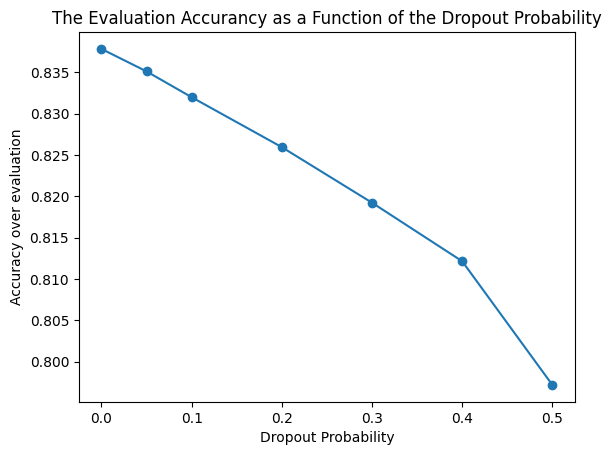

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
#from transformers.callbacks import PrinterCallback, ProgressCallback
import numpy as np
import matplotlib.pyplot as plt
import math
import time

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN_DropOut",
                                  # YOUR CODE HERE
                                  num_train_epochs = 12 , #must be at least 10.
                                  per_device_train_batch_size = 8,
                                  per_device_eval_batch_size = 8,
                                  learning_rate = np.power(10,-3.0),
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
### PART B- dropout ###  
dropout_probs =  [0.0 , 0.05 , 0.1 , 0.2 , 0.3, 0.4, 0.5]
accuracy_values_pB = []
for p in dropout_probs:
  print(f"Training with dropout probability {p}\n")
  print(f"\t prams: num of epoches {training_args.num_train_epochs},\n ")
  print(f"\t prams: batchsize {training_args.per_device_train_batch_size},\n ") 
  print(f"\t prams: learning rate {training_args.learning_rate},\n ")
  print("\t prams: hidden dims [450,100,50,10] \n ")  
  model = DAN_DropOut(p)

  trainer = Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  )
  trainer.train()
  
  
  eval_result = trainer.evaluate()

  
  accuracy = eval_result["eval_accuracy"]
  accuracy_values_pB.append(accuracy)

# Plot the accuracy values of the model with differnent dropout probabilities
plt.plot(dropout_probs, accuracy_values_pB, marker='o')
plt.xlabel('Dropout Probability')
plt.ylabel('Accuracy over evaluation')
plt.title('The Evaluation Accurancy as a Function of the Dropout Probability')
plt.show()



#Part C -different n.o. hidden layers

In [ ]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN_hidden_layers(nn.Module):
  def __init__(self,hidden_layers_lst):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          #part C 
          layers_lst = []
          in_layer_size = 300 
          for layer_indim in hidden_layers_lst: 
            out_hidden_dim = layer_indim
            layers_lst.append(nn.Linear(in_layer_size,out_hidden_dim))
            layers_lst.append(nn.ReLU())
            in_layer_size = out_hidden_dim # next hidden layer has input dimensions as the prev hidden layer output dimensions 
          layers_lst.append(nn.Linear(hidden_layers_lst[-1] if len(hidden_layers_lst)>0 else in_layer_size ,self.num_labels))
          self.layers = nn.Sequential(*layers_lst) # will be stored in self.layers 
            
          self.classifier = nn.Sequential(
              self.layers
          )
          self.loss = nn.CrossEntropyLoss(reduction= 'sum') 
          # END YOUR END

  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      device = torch.device("cuda:0")
      
      # without dropout for part (a) + (c) + (d)
      sumofembed =torch.sum(self.embeddings(input_ids), dim=1).type(torch.FloatTensor)
      attention_vector_per_sample = torch.sum(attention_masks, dim=1,keepdim = True).type(torch.FloatTensor)
      attention_vector_per_sample = torch.sum(attention_masks, dim=1,keepdim = True).type(torch.FloatTensor)
      avg = sumofembed / attention_vector_per_sample
      avg = avg.to(device) #for running on GPU, for nn.linear both input and avg should be on the same device. 
      # END YOUR END
  
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

Training with a DANs' model with  0 hidden layers
	 prams: num of epoches 12,
	 prams: batchsize 8,
	 prams: learning rate 0.001,
	 prams: hidden dims are {hidden_layers_lst}


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 5.2201, 'learning_rate': 0.0009866666666666667, 'epoch': 0.16}
{'loss': 4.8476, 'learning_rate': 0.0009733333333333334, 'epoch': 0.32}
{'loss': 4.5656, 'learning_rate': 0.00096, 'epoch': 0.48}
{'loss': 4.384, 'learning_rate': 0.0009466666666666667, 'epoch': 0.64}
{'loss': 4.3183, 'learning_rate': 0.0009333333333333333, 'epoch': 0.8}
{'loss': 4.1499, 'learning_rate': 0.00092, 'epoch': 0.96}
{'eval_loss': 4.089191436767578, 'eval_accuracy': 0.772, 'eval_runtime': 12.8125, 'eval_samples_per_second': 1951.215, 'eval_steps_per_second': 243.902, 'epoch': 1.0}
{'loss': 4.0461, 'learning_rate': 0.0009066666666666666, 'epoch': 1.12}
{'loss': 3.9555, 'learning_rate': 0.0008933333333333333, 'epoch': 1.28}
{'loss': 3.8111, 'learning_rate': 0.00088, 'epoch': 1.44}
{'loss': 3.8573, 'learning_rate': 0.0008666666666666667, 'epoch': 1.6}
{'loss': 3.8116, 'learning_rate': 0.0008533333333333334, 'epoch': 1.76}
{'loss': 3.781, 'learning_rate': 0.00084, 'epoch': 1.92}
{'eval_loss': 3.7391836643218

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 4.4952, 'learning_rate': 0.0009866666666666667, 'epoch': 0.16}
{'loss': 3.7083, 'learning_rate': 0.0009733333333333334, 'epoch': 0.32}
{'loss': 3.4723, 'learning_rate': 0.00096, 'epoch': 0.48}
{'loss': 3.3424, 'learning_rate': 0.0009466666666666667, 'epoch': 0.64}
{'loss': 3.5765, 'learning_rate': 0.0009333333333333333, 'epoch': 0.8}
{'loss': 3.3387, 'learning_rate': 0.00092, 'epoch': 0.96}
{'eval_loss': 3.5633180141448975, 'eval_accuracy': 0.80464, 'eval_runtime': 12.038, 'eval_samples_per_second': 2076.76, 'eval_steps_per_second': 259.595, 'epoch': 1.0}
{'loss': 3.3804, 'learning_rate': 0.0009066666666666666, 'epoch': 1.12}
{'loss': 3.4327, 'learning_rate': 0.0008933333333333333, 'epoch': 1.28}
{'loss': 3.2052, 'learning_rate': 0.00088, 'epoch': 1.44}
{'loss': 3.3318, 'learning_rate': 0.0008666666666666667, 'epoch': 1.6}
{'loss': 3.3018, 'learning_rate': 0.0008533333333333334, 'epoch': 1.76}
{'loss': 3.2159, 'learning_rate': 0.00084, 'epoch': 1.92}
{'eval_loss': 3.5113413333

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 4.4816, 'learning_rate': 0.0009866666666666667, 'epoch': 0.16}
{'loss': 3.8189, 'learning_rate': 0.0009733333333333334, 'epoch': 0.32}
{'loss': 3.5503, 'learning_rate': 0.00096, 'epoch': 0.48}
{'loss': 3.5068, 'learning_rate': 0.0009466666666666667, 'epoch': 0.64}
{'loss': 3.5454, 'learning_rate': 0.0009333333333333333, 'epoch': 0.8}
{'loss': 3.374, 'learning_rate': 0.00092, 'epoch': 0.96}
{'eval_loss': 3.2568790912628174, 'eval_accuracy': 0.826, 'eval_runtime': 12.5539, 'eval_samples_per_second': 1991.408, 'eval_steps_per_second': 248.926, 'epoch': 1.0}
{'loss': 3.397, 'learning_rate': 0.0009066666666666666, 'epoch': 1.12}
{'loss': 3.4383, 'learning_rate': 0.0008933333333333333, 'epoch': 1.28}
{'loss': 3.2827, 'learning_rate': 0.00088, 'epoch': 1.44}
{'loss': 3.3857, 'learning_rate': 0.0008666666666666667, 'epoch': 1.6}
{'loss': 3.3201, 'learning_rate': 0.0008533333333333334, 'epoch': 1.76}
{'loss': 3.2978, 'learning_rate': 0.00084, 'epoch': 1.92}
{'eval_loss': 3.729530572891

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 4.6763, 'learning_rate': 0.0009866666666666667, 'epoch': 0.16}
{'loss': 3.8203, 'learning_rate': 0.0009733333333333334, 'epoch': 0.32}
{'loss': 3.5474, 'learning_rate': 0.00096, 'epoch': 0.48}
{'loss': 3.483, 'learning_rate': 0.0009466666666666667, 'epoch': 0.64}
{'loss': 3.5987, 'learning_rate': 0.0009333333333333333, 'epoch': 0.8}
{'loss': 3.4368, 'learning_rate': 0.00092, 'epoch': 0.96}
{'eval_loss': 3.5222513675689697, 'eval_accuracy': 0.813, 'eval_runtime': 12.4148, 'eval_samples_per_second': 2013.718, 'eval_steps_per_second': 251.715, 'epoch': 1.0}
{'loss': 3.3694, 'learning_rate': 0.0009066666666666666, 'epoch': 1.12}
{'loss': 3.4123, 'learning_rate': 0.0008933333333333333, 'epoch': 1.28}
{'loss': 3.3091, 'learning_rate': 0.00088, 'epoch': 1.44}
{'loss': 3.3752, 'learning_rate': 0.0008666666666666667, 'epoch': 1.6}
{'loss': 3.3482, 'learning_rate': 0.0008533333333333334, 'epoch': 1.76}
{'loss': 3.2782, 'learning_rate': 0.00084, 'epoch': 1.92}
{'eval_loss': 3.29033851623

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 4.8061, 'learning_rate': 0.0009866666666666667, 'epoch': 0.16}
{'loss': 3.8366, 'learning_rate': 0.0009733333333333334, 'epoch': 0.32}
{'loss': 3.5464, 'learning_rate': 0.00096, 'epoch': 0.48}
{'loss': 3.4257, 'learning_rate': 0.0009466666666666667, 'epoch': 0.64}
{'loss': 3.5506, 'learning_rate': 0.0009333333333333333, 'epoch': 0.8}
{'loss': 3.3847, 'learning_rate': 0.00092, 'epoch': 0.96}
{'eval_loss': 3.6737821102142334, 'eval_accuracy': 0.79912, 'eval_runtime': 12.4063, 'eval_samples_per_second': 2015.11, 'eval_steps_per_second': 251.889, 'epoch': 1.0}
{'loss': 3.4129, 'learning_rate': 0.0009066666666666666, 'epoch': 1.12}
{'loss': 3.4718, 'learning_rate': 0.0008933333333333333, 'epoch': 1.28}
{'loss': 3.2612, 'learning_rate': 0.00088, 'epoch': 1.44}
{'loss': 3.3866, 'learning_rate': 0.0008666666666666667, 'epoch': 1.6}
{'loss': 3.3358, 'learning_rate': 0.0008533333333333334, 'epoch': 1.76}
{'loss': 3.2608, 'learning_rate': 0.00084, 'epoch': 1.92}
{'eval_loss': 3.263687849

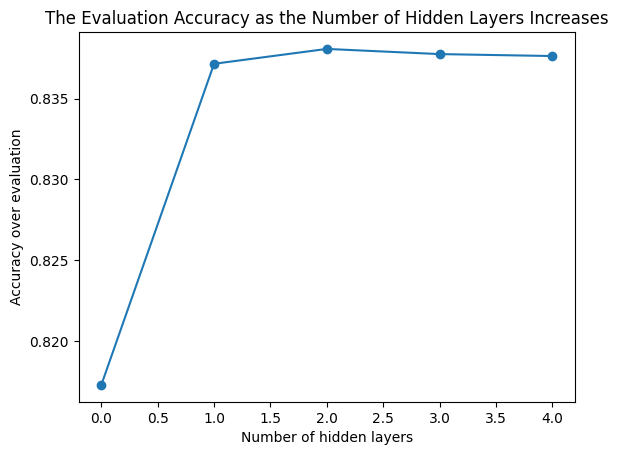

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
#from transformers.callbacks import PrinterCallback, ProgressCallback
import numpy as np
import matplotlib.pyplot as plt
import math
import time


co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN_hidden_layers",
                                  # YOUR CODE HERE
                                  num_train_epochs = 12 , #must be at least 10.
                                  per_device_train_batch_size = 8,
                                  per_device_eval_batch_size = 8,
                                  learning_rate = np.power(10,-3.0),
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")

### PART C - increasing number of hidden layers ###
hidden_layrersdims_lst = [[],[450],[450,100], [450,100,50],[450,100,50,10]]
accuracy_values_pC = []
for hidden_layers_lst in hidden_layrersdims_lst:
  print(f"Training with a DANs' model with  {len(hidden_layers_lst)} hidden layers")
  print(f"\t prams: num of epoches {training_args.num_train_epochs},")
  print(f"\t prams: batchsize {training_args.per_device_train_batch_size},") 
  print(f"\t prams: learning rate {training_args.learning_rate},")
  print("\t prams: hidden dims are {hidden_layers_lst}")  


  model = DAN_hidden_layers(hidden_layers_lst)

  trainer = Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  )
  trainer.train()
  
  
  eval_result = trainer.evaluate()
  accuracy_values_pC.append(eval_result["eval_accuracy"])
nof_hidden_layers = [ 0, 1, 2, 3, 4]
# Plot the accuracy values of the model with  different number of hidden layers.
plt.plot(nof_hidden_layers, accuracy_values_pC, marker='o')
plt.xlabel('Number of hidden layers')
plt.ylabel('Accuracy over evaluation')
plt.title('The Evaluation Accuracy as the Number of Hidden Layers Increases')
plt.show()




#Part D - different activation functions

In [ ]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN_activations(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          # #PART D- 
          layers_lst = []
          activations = [nn.LeakyReLU(), nn.ReLU(),nn.Hardswish(),nn.ReLU()]
          hidden_layrersdims_lst = [450,100,50,10]
          in_layer_size = 300 
          for layer_indim , act_func_layer in zip(hidden_layrersdims_lst,activations): 
            out_hidden_dim = layer_indim
            layers_lst.append(nn.Linear(in_layer_size,out_hidden_dim))
            layers_lst.append(act_func_layer)
            in_layer_size = out_hidden_dim # next hidden layer has input dimensions as the prev hidden layer output dimensions 
          layers_lst.append(nn.Linear(hidden_layrersdims_lst[-1] if len(hidden_layrersdims_lst)>0 else in_layer_size ,self.num_labels))
          self.layers = nn.Sequential(*layers_lst) # will be stored in self.layers 
            
          self.classifier = nn.Sequential(
              self.layers
          )
          self.loss = nn.CrossEntropyLoss(reduction= 'sum') 
           # END YOUR END


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      device = torch.device("cuda:0")
      
      # without dropout for part (a) + (c) + (d)
      sumofembed =torch.sum(self.embeddings(input_ids), dim=1).type(torch.FloatTensor)
      attention_vector_per_sample = torch.sum(attention_masks, dim=1,keepdim = True).type(torch.FloatTensor)
      attention_vector_per_sample = torch.sum(attention_masks, dim=1,keepdim = True).type(torch.FloatTensor)
      avg = sumofembed / attention_vector_per_sample
      avg = avg.to(device) #for running on GPU, for nn.linear both input and avg should be on the same device. 
      
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 4.6982, 'learning_rate': 0.0009866666666666667, 'epoch': 0.16}
{'loss': 3.9559, 'learning_rate': 0.0009733333333333334, 'epoch': 0.32}
{'loss': 3.5847, 'learning_rate': 0.00096, 'epoch': 0.48}
{'loss': 3.5012, 'learning_rate': 0.0009466666666666667, 'epoch': 0.64}
{'loss': 3.5772, 'learning_rate': 0.0009333333333333333, 'epoch': 0.8}
{'loss': 3.4122, 'learning_rate': 0.00092, 'epoch': 0.96}
{'eval_loss': 3.428211212158203, 'eval_accuracy': 0.8194, 'eval_runtime': 12.7518, 'eval_samples_per_second': 1960.51, 'eval_steps_per_second': 245.064, 'epoch': 1.0}
{'loss': 3.4145, 'learning_rate': 0.0009066666666666666, 'epoch': 1.12}
{'loss': 3.5949, 'learning_rate': 0.0008933333333333333, 'epoch': 1.28}
{'loss': 3.3068, 'learning_rate': 0.00088, 'epoch': 1.44}
{'loss': 3.443, 'learning_rate': 0.0008666666666666667, 'epoch': 1.6}
{'loss': 3.3585, 'learning_rate': 0.0008533333333333334, 'epoch': 1.76}
{'loss': 3.2858, 'learning_rate': 0.00084, 'epoch': 1.92}
{'eval_loss': 3.299133777618

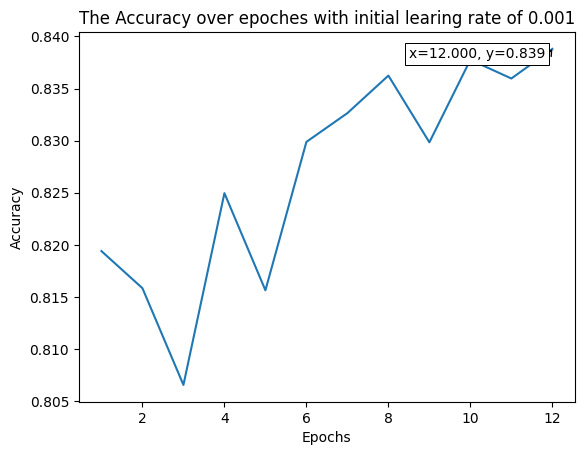

{'train_runtime': 570.2252, 'train_samples_per_second': 526.108, 'train_steps_per_second': 65.763, 'train_loss': 3.1678914029947918, 'epoch': 12.0}


TrainOutput(global_step=37500, training_loss=3.1678914029947918, metrics={'train_runtime': 570.2252, 'train_samples_per_second': 526.108, 'train_steps_per_second': 65.763, 'train_loss': 3.1678914029947918, 'epoch': 12.0})

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
#from transformers.callbacks import PrinterCallback, ProgressCallback
import numpy as np
import matplotlib.pyplot as plt
import math
import time

class MyCallbacks(TrainerCallback):
    def _init_(self):
        super().__init__()
        self.epochs_lst = None
        self.accuracy_over_epochs_lst = None
        self.accuracy_over_learning_rate_lst = None
        self.learning_rate_lst = None
       
    def on_train_begin(self, args, state, control, **kwargs):
        self.epochs_lst = []
        self.accuracy_over_epochs_lst = []

        
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        self.accuracy_over_epochs_lst.append(metrics['eval_accuracy'])
        self.epochs_lst.append(state.epoch)
    
        if (state.epoch == args.num_train_epochs):
          annot_max(self.epochs_lst,self.accuracy_over_epochs_lst)
          plt.plot(self.epochs_lst, self.accuracy_over_epochs_lst)
          plt.xlabel('Epochs')
          plt.ylabel('Accuracy')
          plt.title(f'The Accuracy over epoches with initial learing rate of {args.learning_rate}')
          plt.show()

#PART D - experimenting with different activation functions.
mycallbacks = MyCallbacks()
co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN_activations",
                                  # YOUR CODE HERE
                                  num_train_epochs = 12 , #must be at least 10.
                                  per_device_train_batch_size = 8,
                                  per_device_eval_batch_size = 8,
                                  learning_rate = np.power(10,-3.0),
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN_activations()

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                # YOUR CODE HERE
                  mycallbacks
                #ProgressCallback(),
                # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.train() 



#Part E 

In [11]:
# PART E (same model as part A without callbacks)
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.layers = nn.Sequential(
              nn.Linear(300, 450),
              nn.ReLU(),
              nn.Linear(450, 100),
              nn.ReLU(),
              nn.Linear(100, 50),
              nn.ReLU(),
              nn.Linear(50, 10),
              nn.ReLU(),
              nn.Linear(10,self.num_labels),
          )   
          self.classifier = nn.Sequential(
              self.layers
          )
          self.loss = nn.CrossEntropyLoss(reduction= 'sum') 
          # END YOUR END


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      device = torch.device("cuda:0")
      
      # without dropout for part (a)
      sumofembed =torch.sum(self.embeddings(input_ids), dim=1).type(torch.FloatTensor)
      attention_vector_per_sample = torch.sum(attention_masks, dim=1,keepdim = True).type(torch.FloatTensor)
      attention_vector_per_sample = torch.sum(attention_masks, dim=1,keepdim = True).type(torch.FloatTensor)
      avg = sumofembed / attention_vector_per_sample
      avg = avg.to(device) #for running on GPU, for nn.linear both input and avg should be on the same device.  
      # END YOUR END
  
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}


In [13]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
#from transformers.callbacks import PrinterCallback, ProgressCallback
import numpy as np
import matplotlib.pyplot as plt
import math
import time

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs = 20 , #must be at least 10.
                                  per_device_train_batch_size = 8,
                                  per_device_eval_batch_size = 8,
                                  learning_rate = np.power(10,-3.0),
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                # YOUR CODE HERE
                # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.362500,3.299210,0.821040
2,3.302300,3.119267,0.826800
3,3.395600,3.759137,0.798960
4,3.154700,3.292088,0.831960
5,3.231000,3.313824,0.831640
6,3.056200,3.314749,0.816840
7,3.153700,3.188519,0.832560
8,3.134200,3.103185,0.829160
9,3.028900,4.208120,0.804520
10,3.017100,3.488600,0.829400


TrainOutput(global_step=62500, training_loss=3.08718082421875, metrics={'train_runtime': 951.4933, 'train_samples_per_second': 525.49, 'train_steps_per_second': 65.686, 'total_flos': 0.0, 'train_loss': 3.08718082421875, 'epoch': 20.0})

In [14]:
#Q5-PART E
pred_res = trainer.predict(trainer.eval_dataset)
print(pred_res)
logits = pred_res.predictions
true_labels = pred_res.label_ids
predictions = np.argmax(logits, axis=-1)
num_samples = 0
for i, (cur_pred, cur_true_label,logits) in enumerate(zip(predictions,true_labels,logits)):
  if (cur_pred != cur_true_label) and (num_samples < 8) :
    print(f"index = {i}")
    print("\t Input:", trainer.eval_dataset[i]['text']) 
    print("\t The true label ", cur_true_label)
    print("\t The predicted Label:", cur_pred)
    print("\t The logits :", logits)
    num_samples += 1 
  if(num_samples == 8):
    break



PredictionOutput(predictions=array([[-0.94667107,  1.2267199 ],
       [ 0.6980805 , -0.38489342],
       [ 0.99385697, -0.6644377 ],
       ...,
       [-0.60592526,  0.8901779 ],
       [ 0.66051835, -0.3508677 ],
       [ 0.8004817 , -0.48197186]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 1, 0]), metrics={'test_loss': 3.089113235473633, 'test_accuracy': 0.83916, 'test_runtime': 13.2044, 'test_samples_per_second': 1893.306, 'test_steps_per_second': 236.663})
index = 1
	 Input: This is the latest entry in the long series of films with the French agent, O.S.S. 117 (the French answer to James Bond). The series was launched in the early 1950's, and spawned at least eight films (none of which was ever released in the U.S.). 'O.S.S.117:Cairo,Nest Of Spies' is a breezy little comedy that should not...repeat NOT, be taken too seriously. Our protagonist finds himself in the middle of a spy chase in Egypt (with Morroco doing stand in for Egypt) to find out about a long lost friend. Wh